# Preprocessing and Modelling Pre-Omicron

In [6]:

import numpy as np
import pandas as pd

from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
import seaborn as sns

import csv 
from collections import Counter
import datetime
import holidays
from sklearn.base import BaseEstimator, TransformerMixin


from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from scipy.sparse import csr_matrix

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import OLSInfluence
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

from lineartree import LinearTreeRegressor

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, cross_validate
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, explained_variance_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor



#### When first modelling, I had one notebook. I ran the first linear models against the original data and just the school-aged population and school status columns. Below, I am running them with all my engineered features.


In [7]:
merged_df_pre_omi = pd.read_csv('data/pre_omi.csv')

merged_df_pre_omi['Test Date'] = pd.to_datetime(merged_df_pre_omi['Test Date'])

merged_df_pre_omi['School Status'] = merged_df_pre_omi['School Status'].astype('object')
merged_df_pre_omi['School-Aged Population']

0        72091.0
1       122994.0
2       117865.0
3       151282.0
4       131881.0
          ...   
1479     46435.0
1480     33636.0
1481     29986.0
1482     74748.0
1483    240219.0
Name: School-Aged Population, Length: 1484, dtype: float64

#### Simple preprocessing. Not going to worry about scaling right now. Just attempting to determine if my features are  strong enough to warrant continuing.

In [8]:
cat_cols = []

for i in merged_df_pre_omi.columns:
    if i == 'Gene Copies (N1/L)' or i == 'Test Date' or i == 'Holiday' or i == 'Sample Date':
        pass
    elif merged_df_pre_omi[i].dtype == 'object':
        cat_cols.append(i)
        print(i)
    elif merged_df_pre_omi[i].dtype == 'float64' or merged_df_pre_omi[i].dtype == 'int64':
        print(i)
    else:
        print("error")


cat_transformer = Pipeline(steps=[  
    ('cat_encoder', OneHotEncoder(handle_unknown='ignore'))                     
])
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_transformer, cat_cols),
    ])

y = merged_df_pre_omi['Gene Copies (N1/L)']

X = merged_df_pre_omi.drop('Gene Copies (N1/L)', axis=1)

X_train ,X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


WRRF Name
Per Capita Gene Copies
Population Served, estimated
School Status
School-Aged Population
Season


In [11]:
# Setting up columns to be onehot encoded. We will look at numerical transformation later

# Have to drop the NaNs, otherwise linear model won't work

y_train = y_train.dropna()
X_train = X_train.dropna()
X_test = X_test.dropna()
y_test = y_test.dropna()

linreg = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

linreg.fit(X_train, y_train)


y_pred=linreg.predict(X_test)

linreg.score(X_train,y_train)



0.5587991188685084

In [12]:
linear_model = linreg.named_steps['model']

# Print the coefficients along with column names
for feature_name, coef in zip(X.columns, linear_model.coef_):
    print(f"{feature_name}: {coef}")

Sample Date: -1070.2982270060952
Test Date: 1000.1580037146778
WRRF Name: 1133.043333951316
Per Capita Gene Copies: -729.9289403163428
Population Served, estimated: 3534.929886399773
School Status: -1595.292150257837
School-Aged Population: -2604.654484580207
Season: 1246.104726306294
Holiday: 6245.974160965021


#### With the addition of jewish holidays, got a 1% boost in the r2 score. Might get a little nudge with Islamic, but probably not much.

(cell was deleted)


#### Trying without the highly-correlated features

In [17]:
copy_df = merged_df_pre_omi.copy()

copy_df.dropna(inplace=True)

y = copy_df['Gene Copies (N1/L)']


X = copy_df.drop(columns=['Gene Copies (N1/L)','Population Served, estimated', 'Per Capita Gene Copies'], axis=1)

# Split again
X_train ,X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


# Log transforming the target

y_test = np.log(y_test)
y_train = np.log(y_train)

# 3rd iteration, no adjustments to the model itself

linreg_3 = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

linreg_3.fit(X_train, y_train)

y_pred = linreg_3.predict(X_test)

linreg_3.score(X_train,y_train)

0.6177258476117596

In [18]:
linear_model = linreg_3.named_steps['model']

# Print the coefficients along with column names
for feature_name, coef in zip(X.columns, linear_model.coef_):
    print(f"{feature_name}: {coef}")

Sample Date: -0.14757150645203634
Test Date: 0.17730798873563733
WRRF Name: 0.21434747417862648
School Status: -0.1206607271795389
School-Aged Population: 0.28797817715926266
Season: -0.1298456319366709
Holiday: -0.3610885764908265


#### Slightly worse score without the non-school population data. So even though it's correlated, the general population data is not boosting the score much. 

#### Let's look at just the school-related data.

In [19]:
copy_df_2 = merged_df_pre_omi.copy()
copy_df_2.dropna(inplace=True)

y = copy_df_2['Gene Copies (N1/L)']

X = copy_df_2[['School-Aged Population', 'School Status']]


# We only have one column to transform in this version

cat_cols_2 = ['School Status']

preprocessor_2 = ColumnTransformer(
    transformers=[
        ('cat', cat_transformer, cat_cols_2),
    ])

X_train ,X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [20]:
# 4th model - this one is actually different!

linreg_4 = Pipeline([
    ('preprocessor', preprocessor_2),
    ('model', LinearRegression())
])

linreg_4.fit(X_train, y_train)

y_pred = linreg_4.predict(X_test)

linreg_4.score(X_train,y_train)

0.46997170371988195

#### With just the school-aged population and school status, our model explains nearly half the variance! And this is before log transformation!


In [21]:
# Same model, log-transformed target data.
y_train = np.log(y_train)
y_test = np.log(y_test)

linreg_5 = Pipeline([
    ('preprocessor', preprocessor_2),
    ('model', LinearRegression())
])

linreg_5.fit(X_train, y_train)

y_pred = linreg_5.predict(X_test)

print(linreg_5.score(X_train,y_train))
print(r2_score(y_test, y_pred))

0.5422711234817856
0.5143954687950946


#### Ok, our train tests scores are pretty close! Not too much overfitting.


In [22]:
# New X and y

copy_df_3 = merged_df_pre_omi.copy()
copy_df_3.dropna(inplace=True)
y = copy_df_3['Gene Copies (N1/L)']

X = copy_df_3['School-Aged Population']


# Split again

X_train ,X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# log transform again

y_train = np.log(y_train)
y_test = np.log(y_test)

# using ols because we are not preprocessing this data
X_int = sm.add_constant(X_train)
results = sm.OLS(y_train, X_int).fit()
summary = results.summary()
print(summary)

influence = OLSInfluence(results)
print(influence.resid_studentized)

                            OLS Regression Results                            
Dep. Variable:     Gene Copies (N1/L)   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     8.238
Date:                Wed, 04 Oct 2023   Prob (F-statistic):            0.00418
Time:                        21:45:30   Log-Likelihood:                -1784.3
No. Observations:                1097   AIC:                             3573.
Df Residuals:                    1095   BIC:                             3583.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      8

#### Well, this isn't very good! This is just school-aged population, though, and not the actual status of schools

#### Wonder how predictive the baseline model is. Let's just look at the original population data, which is one ofthe most relevant features. 

In [23]:
copy_df_4 = merged_df_pre_omi.copy()
copy_df_4.dropna(inplace=True)

y = copy_df_4['Gene Copies (N1/L)']
X = copy_df_4['Population Served, estimated']

X_train ,X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

y_train = np.log(y_train)
y_test = np.log(y_test)

X_int = sm.add_constant(X_train)
model_2 = sm.OLS(y_train, X_int).fit()

summary = model_2.summary()
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     Gene Copies (N1/L)   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     11.33
Date:                Wed, 04 Oct 2023   Prob (F-statistic):           0.000791
Time:                        21:45:40   Log-Likelihood:                -1782.7
No. Observations:                1097   AIC:                             3569.
Df Residuals:                    1095   BIC:                             3579.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            8.0670      0.075    106.995      0.000       7.919       8.215
Population Served, estimated  3.618e-07   1.08e-07      3.365      0.001    1.51e-07    5.73e-07
==============================================================================
Omnibus:                       61.143   Durbin-Watson:                   2.034
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.686
Skew:                          -0.330   Prob(JB):                     3.98e-09
Kurtosis:                       2.359   Cond. No.                     1.42e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.42e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [24]:
copy_df_5 = merged_df_pre_omi.copy()
copy_df_5.dropna(inplace=True)
y = copy_df_5['Gene Copies (N1/L)']

X = copy_df_5[['Population Served, estimated', 'WRRF Name', 'Per Capita Gene Copies', 'Sample Date', 'Test Date']]

X_train ,X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


y_train = np.log(y_train)
y_test = np.log(y_test)

In [25]:
cat_cols_3 = ['WRRF Name']

cat_transformer = Pipeline(steps=[  
    ('cat_encoder', OneHotEncoder(handle_unknown='ignore'))                     
])

preprocessor_3 = ColumnTransformer(
    transformers=[
        ('cat', cat_transformer, cat_cols_3),
    ])

linreg_6 = Pipeline([
    ('preprocessor', preprocessor_3),
    ('model', LinearRegression())
])

linreg_6.fit(X_train, y_train)

y_pred = linreg_6.predict(X_test)

print(linreg_6.score(X_train,y_train))
print(r2_score(y_test, y_pred))

0.07123753415992828
0.04505102157812135


#### So yeah, the basic info from the original dataset explains almost nothing. 

#### Want to use the index (sample date) as a feature*. Let's also save this data file as a csv, since it's what we ultimately want to use.
* Was originally attempting to model as time-series

In [26]:
sample_date_df = merged_df_pre_omi.copy()
sample_date_df['Sample Date'] = pd.to_datetime(sample_date_df['Sample Date'])

# sample_date_df.to_csv('data/master_wastewater.csv', index=False)

#(Ending up abandoning dates as features, but in future work would like to integrate them.)

#### Fancier models! Going to move on to more elaborate models, including Random Forest. Re-doing the columns for preprocessing since we have different features


In [27]:
date_cols = []
cat_cols = []  
num_cols = []   

for i in sample_date_df.columns:
    if i == 'Gene Copies (N1/L)' or i == 'Holiday':
        pass
    elif sample_date_df[i].dtype == 'datetime64[ns]':
        date_cols.append(i)
    elif sample_date_df[i].dtype == 'object':
        cat_cols.append(i)
    elif i == 'Sample Date':
        date_cols.append(i)
    elif sample_date_df[i].dtype == 'float64' or sample_date_df[i].dtype == 'int64':
        num_cols.append(i)
    else:
        print("error")
        


print(date_cols)
print(cat_cols)
print(num_cols)
# leaving "holiday" out because we don't want to transform this binary data

['Sample Date', 'Test Date']
['WRRF Name', 'School Status', 'Season']
['Per Capita Gene Copies', 'Population Served, estimated', 'School-Aged Population']


#### Custom function Allows for fit and transformation of linear features in a pipeline. Were originally trying to combineLinearRegressor with RandomForest using FeatureUnion, but was unsuccessful

In [28]:
class ColumnSelector(BaseEstimator, TransformerMixin): 
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.columns]
    

#### Just going with a vanilla Random Forest model after trying to combine a linear regression and random forest.


In [29]:
# New X and y, split

sample_copy_df = sample_date_df.copy()
sample_copy_df.dropna(inplace=True)

X = sample_copy_df.drop('Gene Copies (N1/L)', axis=1)

y = sample_copy_df['Gene Copies (N1/L)']


X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

y_train = np.log(y_train)
y_test = np.log(y_test)

# New preprocessors

cat_preprocessor = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numeric_preprocessor = Pipeline([
    ('selector', ColumnSelector(columns=num_cols)), 
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('cat', cat_preprocessor, cat_cols),
    ('num', numeric_preprocessor, num_cols),
])


rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model',  RandomForestRegressor(random_state = 42))
])


rf_pipeline.fit(X_train, y_train)


y_pred = rf_pipeline.predict(X_test)

print(f'R-squared score on training data: {rf_pipeline.score(X_train, y_train)}')
print(f'R2 test score: {r2_score(y_test, y_pred)}')
print(f'Mean squared error: {mean_squared_error(y_test, y_pred)}')
print(f'Mean absolute error: {mean_absolute_error(y_test, y_pred)}')
print(f'Mean absolute percentage error: {mean_absolute_percentage_error(y_test, y_pred)}')
print(f'Explained variance score (modified R2): {explained_variance_score(y_test, y_pred)}')

R-squared score on training data: 0.9951082673198972
R2 test score: 0.9675638498965449
Mean squared error: 0.052094098364203714
Mean absolute error: 0.15678014488775047
Mean absolute percentage error: 0.019586285838186914
Explained variance score (modified R2): 0.9675841799049261


#### Wow, 99.5%!  Let's look at feature importances.

In [30]:
rf_model = rf_pipeline.named_steps['model']
features = []
scores = []

# Print the coefficients along with column names
for feature_name, importance in zip(X.columns, rf_model.feature_importances_):
    features.append(feature_name)
    scores.append(importance)
    
ranked_scores = sorted(zip(scores, features), reverse=True)
for score, feature in ranked_scores:
    print(f'{score}: {feature}')

0.0033534293203989632: Sample Date
0.0013350698361288351: Holiday
0.0013342269200147376: Test Date
0.001027440180672196: School-Aged Population
0.00101529776794821: Season
0.0008777949385026092: Population Served, estimated
0.0006330406638788463: Per Capita Gene Copies
0.00044756918311024147: WRRF Name
0.00036113194992653256: School Status


In [31]:
cross_validate(rf_pipeline, X_train, y_train, return_train_score=True)

{'fit_time': array([0.80778694, 0.82285213, 0.80137396, 0.79649496, 0.7987268 ]),
 'score_time': array([0.01656199, 0.01640391, 0.0159421 , 0.01623011, 0.01560235]),
 'test_score': array([0.97273797, 0.96571812, 0.96220805, 0.96419641, 0.95084884]),
 'train_score': array([0.99458214, 0.99494814, 0.99498579, 0.99466468, 0.99549897])}

#### Want to try this model again without the date features, since they seem to be over-determining.


In [32]:
sample_copy_df_2 = sample_date_df.copy()

sample_copy_df_2.dropna(inplace=True)

X = sample_copy_df_2.drop(['Gene Copies (N1/L)', 'Sample Date', 'Test Date'], axis=1)

y = sample_copy_df_2['Gene Copies (N1/L)']

X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

y_train = np.log(y_train)
y_test = np.log(y_test)

date_cols = []
cat_cols = []  
num_cols = []   

for i in sample_date_df.columns:
    if i == 'Gene Copies (N1/L)' or i == 'Holiday':
        pass
    elif sample_date_df[i].dtype == 'datetime64[ns]':
        date_cols.append(i)
    elif sample_date_df[i].dtype == 'object':
        cat_cols.append(i)
    elif i == 'Sample Date':
        date_cols.append(i)
    elif sample_date_df[i].dtype == 'float64' or sample_date_df[i].dtype == 'int64':
        num_cols.append(i)
    else:
        print("error")
        


print(date_cols)
print(cat_cols)
print(num_cols)

['Sample Date', 'Test Date']
['WRRF Name', 'School Status', 'Season']
['Per Capita Gene Copies', 'Population Served, estimated', 'School-Aged Population']


In [ ]:
# Adding in numeric scaling

cat_preprocessor = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numeric_preprocessor = Pipeline([
    ('selector', ColumnSelector(columns=num_cols)), 
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('cat', cat_preprocessor, cat_cols),
    ('num', numeric_preprocessor, num_cols),
])


rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model',  RandomForestRegressor(random_state = 42))
])



rf_pipeline.fit(X_train, y_train)  # Same pipeline, different data


y_pred = rf_pipeline.predict(X_test)


print(f'R-squared score on training data: {rf_pipeline.score(X_train, y_train)}')
print(f'R2 test score: {r2_score(y_test, y_pred)}')
print(f'Mean squared error: {mean_squared_error(y_test, y_pred)}')
print(f'Mean absolute error: {mean_absolute_error(y_test, y_pred)}')
print(f'Mean absolute percentage error: {mean_absolute_percentage_error(y_test, y_pred)}')
print(f'Explained variance score (modified R2): {explained_variance_score(y_test, y_pred)}')

#### The very same! Our engineered features are very strong all around. Let's look at feature importance.


In [33]:
rf_model = rf_pipeline.named_steps['model']
features = []
scores = []
# Print the coefficients along with column names
for feature_name, importance in zip(X.columns, rf_model.feature_importances_):
    features.append(feature_name)
    scores.append(importance)
    
ranked_scores = sorted(zip(scores, features), reverse=True)
for score, feature in ranked_scores:
    print(f'{score}: {feature}')

0.0033534293203989632: WRRF Name
0.0013342269200147376: Per Capita Gene Copies
0.001027440180672196: Holiday
0.0008777949385026092: School-Aged Population
0.0006330406638788463: School Status
0.00044756918311024147: Population Served, estimated
0.00036113194992653256: Season


#### Let's try another model type, using all features

In [34]:
sample_copy_df = sample_date_df.copy()

X = sample_copy_df.drop('Gene Copies (N1/L)', axis=1)

y = sample_copy_df['Gene Copies (N1/L)']

X.dropna(inplace=True)
y.dropna(inplace=True)

X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

y_train = np.log(y_train)
y_test = np.log(y_test)

grad = GradientBoostingRegressor()

grad_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model',  grad)
])


grad_pipeline.fit(X_train, y_train)
y_pred = grad_pipeline.predict(X_test)

print(f'R-squared score on training data: {grad_pipeline.score(X_train, y_train)}')
print(f'R2 test score: {r2_score(y_test, y_pred)}')
print(f'Mean squared error: {mean_squared_error(y_test, y_pred)}')
print(f'Mean absolute error: {mean_absolute_error(y_test, y_pred)}')
print(f'Mean absolute percentage error: {mean_absolute_percentage_error(y_test, y_pred)}')
print(f'Explained variance score (modified R2 test score): {explained_variance_score(y_test, y_pred)}')

R-squared score on training data: 0.9814959729055575
R2 test score: 0.9722986366671642
Mean squared error: 0.044489791226165705
Mean absolute error: 0.14425675395770118
Mean absolute percentage error: 0.017997372374729665
Explained variance score (modified R2 test score): 0.9723035942512742


#### Pretty similar!

In [35]:
grad_model = grad_pipeline.named_steps['model']
features = []
scores = []
# Print the coefficients along with column names
for feature_name, importance in zip(X.columns, grad_model.feature_importances_):
    features.append(feature_name)
    scores.append(importance)
    
ranked_scores = sorted(zip(scores, features), reverse=True)
for score, feature in ranked_scores:
    print(f'{score}: {feature}')

0.003964230615167441: Sample Date
0.0018557842350581746: Holiday
0.0010896138197174798: School-Aged Population
0.0007375077923084702: Season
0.000679885943293954: Population Served, estimated
0.0004589845674212497: Test Date
0.0003816646083538956: Per Capita Gene Copies
1.2469364846435174e-05: School Status
9.791200094239643e-06: WRRF Name


#### Very different weighing of features here, and slightly better test score. Let's look at loss scores, too:

In [36]:
train_score = grad_pipeline['model'].train_score_
train_score

# If we ran maybe double the iteratations, our loss score should approach .2

array([1.2546271 , 1.0343755 , 0.85524127, 0.70958707, 0.59109145,
       0.4945883 , 0.41586988, 0.35165381, 0.29935438, 0.25651436,
       0.221891  , 0.19355449, 0.17034788, 0.15123911, 0.13525078,
       0.12200857, 0.11088258, 0.10184361, 0.09408602, 0.08763019,
       0.08227315, 0.07697006, 0.07258206, 0.0690886 , 0.06602022,
       0.06324645, 0.06088238, 0.05882038, 0.05690847, 0.05521488,
       0.05357605, 0.05218039, 0.05038489, 0.04914069, 0.04801434,
       0.04685401, 0.04577433, 0.04487213, 0.04399308, 0.04311993,
       0.0423678 , 0.04161209, 0.04089222, 0.03969664, 0.03909103,
       0.03846022, 0.03794208, 0.03745044, 0.03702689, 0.03632175,
       0.03593234, 0.03559401, 0.03521393, 0.03492283, 0.03463449,
       0.0343394 , 0.03404891, 0.03374259, 0.03347791, 0.03326131,
       0.03307398, 0.03287956, 0.03270017, 0.0324756 , 0.03231803,
       0.03210624, 0.03182856, 0.03168736, 0.03153384, 0.03138392,
       0.0312248 , 0.03109716, 0.03097769, 0.03087304, 0.03076

#### Let's get rid of all date features with this model and see what happens

In [37]:
sample_copy_df = sample_date_df.copy()

X = sample_copy_df.drop(columns=['Gene Copies (N1/L)','Sample Date', 'Test Date'], axis=1)

y = sample_copy_df['Gene Copies (N1/L)']

X.dropna(inplace=True)
y.dropna(inplace=True)

X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

y_train = np.log(y_train)
y_test = np.log(y_test)

grad = GradientBoostingRegressor()
grad_best_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model',  grad)
])

grad_best_pipeline.fit(X_train, y_train)
y_pred = grad_best_pipeline.predict(X_test)

print(f'R-squared score on training data: {grad_best_pipeline.score(X_train, y_train)}')
print(f'R2 test score: {r2_score(y_test, y_pred)}')
print(f'Mean squared error: {mean_squared_error(y_test, y_pred)}')
print(f'Mean absolute error: {mean_absolute_error(y_test, y_pred)}')
print(f'Mean absolute percentage error: {mean_absolute_percentage_error(y_test, y_pred)}')
print(f'Explained variance score (modified R2 test score): {explained_variance_score(y_test, y_pred)}')

R-squared score on training data: 0.9814959729055575
R2 test score: 0.9722981859722336
Mean squared error: 0.04449051506502981
Mean absolute error: 0.14426369928885208
Mean absolute percentage error: 0.017999813555043806
Explained variance score (modified R2 test score): 0.9723030323414651


#### Very similar scores, with less over-fitting. Good! Let's examine feature importance.

In [38]:
grad_model = grad_best_pipeline.named_steps['model']
features = []
scores = []
# Print the coefficients along with column names
for feature_name, importance in zip(X.columns, grad_model.feature_importances_):
    features.append(feature_name)
    scores.append(importance)
    
ranked_scores = sorted(zip(scores, features), reverse=True)
for score, feature in ranked_scores:
    print(f'{score}: {feature}')

0.003964230615167439: WRRF Name
0.0010896138197174702: Holiday
0.0006809766196326062: School-Aged Population
0.00045898456742125116: Per Capita Gene Copies
0.000381664608353893: School Status
1.3389725489198476e-05: Season
9.791200094236182e-06: Population Served, estimated


#### Going to remove highly-correlated non-engineered features, to better see how strong the model is with my contibutions.


In [39]:
sample_copy_df = sample_date_df.copy()

sample_copy_df.dropna(inplace=True)

X = sample_copy_df.drop(columns=['Gene Copies (N1/L)','Sample Date', 'Test Date', 'Population Served, estimated', 'Per Capita Gene Copies'], axis=1)

y = sample_copy_df['Gene Copies (N1/L)']

X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

y_train = np.log(y_train)
y_test = np.log(y_test)

# Re-do preprocesing as we have different features
date_cols = []
cat_cols = []  
num_cols = []   

for i in sample_date_df.columns:
    if i == 'Gene Copies (N1/L)' or i == 'Holiday' or i == 'Population Served, estimated' or i == 'Per Capita Gene Copies':
        pass
    elif sample_date_df[i].dtype == 'datetime64[ns]':
        date_cols.append(i)
    elif sample_date_df[i].dtype == 'object':
        cat_cols.append(i)
    elif i == 'Sample Date':
        date_cols.append(i)
    elif sample_date_df[i].dtype == 'float64' or sample_date_df[i].dtype == 'int64':
        num_cols.append(i)
    else:
        print("error")
        


print(date_cols)
print(cat_cols)
print(num_cols)
# leaving "holiday" out because we don't want to transform this binary data

['Sample Date', 'Test Date']
['WRRF Name', 'School Status', 'Season']
['School-Aged Population']


In [ ]:
cat_transformer = Pipeline(steps=[  
    ('cat_encoder', OneHotEncoder(handle_unknown='ignore'))                     
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_transformer, cat_cols),
    ])

grad = GradientBoostingRegressor()
grad_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model',  grad)
])

grad_pipeline.fit(X_train, y_train)
y_pred = grad_pipeline.predict(X_test)

print(f'R-squared score on training data: {grad_pipeline.score(X_train, y_train)}')
print(f'R2 test score: {r2_score(y_test, y_pred)}')
print(f'Mean squared error: {mean_squared_error(y_test, y_pred)}')
print(f'Mean absolute error: {mean_absolute_error(y_test, y_pred)}')
print(f'Mean absolute percentage error: {mean_absolute_percentage_error(y_test, y_pred)}')
print(f'Explained variance score (modified R2 test score): {explained_variance_score(y_test, y_pred)}')

#### Looking at feature importances

In [40]:
grad_model = grad_pipeline.named_steps['model']
features = []
scores = []
# Print the coefficients along with column names
for feature_name, importance in zip(X.columns, grad_model.feature_importances_):
    features.append(feature_name)
    scores.append(importance)
    
ranked_scores = sorted(zip(scores, features), reverse=True)
for score, feature in ranked_scores:
    print(f'{score}: {feature}')

0.003964230615167441: WRRF Name
0.000679885943293954: Holiday
0.0004589845674212497: School Status
0.0003816646083538956: Season
9.791200094239643e-06: School-Aged Population


#### Analysis: 

By removing correlated features, our score was reduced dramatically. However, there seem to be important elements of the non-date correlated features that we should keep, because although they are similar, they tell us important things about the data at particular times (as opposed to our scores, which cover the entire data period). For instance, sudden wastewater spikes around school events in places with high school-aged populations. Over time, these effects are expected to flatten out and/or become more cyclical. One avenue to pursue later would be population estimates of those who left the city during 2020/2021 but who were never officially non-residents, and thus not reflected in the Census Bureau's data. We would expect much more of this in wealthier zipcodes and in zipcodes where there are fewer children. 

#### Setting up for grid search of our best model so far. Re-doing preprocessing since using different features


In [41]:
date_cols = []
cat_cols = []  
num_cols = []   

for i in sample_date_df.columns:
    if i == 'Gene Copies (N1/L)' or i == 'Holiday':
        pass
    elif sample_date_df[i].dtype == 'datetime64[ns]':
        date_cols.append(i)
    elif sample_date_df[i].dtype == 'object':
        cat_cols.append(i)
    elif i == 'Sample Date':
        date_cols.append(i)
    elif sample_date_df[i].dtype == 'float64' or sample_date_df[i].dtype == 'int64':
        num_cols.append(i)
    else:
        print("error")
        
print(date_cols)
print(cat_cols)
print(num_cols)

cat_preprocessor = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numeric_preprocessor = Pipeline([
    ('selector', ColumnSelector(columns=num_cols)), 
    ('scaler', StandardScaler())
])


preprocessor = ColumnTransformer([
    ('cat', cat_preprocessor, cat_cols),
    ('num', numeric_preprocessor, num_cols),
])


['Sample Date', 'Test Date']
['WRRF Name', 'School Status', 'Season']
['Per Capita Gene Copies', 'Population Served, estimated', 'School-Aged Population']


#### Removing the datetime info and running grid search on our best model.


In [42]:
sample_copy_df = sample_date_df.copy()
sample_copy_df.dropna(inplace=True)

X = sample_copy_df.drop(columns=['Gene Copies (N1/L)','Sample Date', 'Test Date'], axis=1)

y = sample_copy_df['Gene Copies (N1/L)']

X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

y_train = np.log(y_train)

y_test = np.log(y_test)

grad = GradientBoostingRegressor()

param_grid = {
    'model__learning_rate': [.01, .1, .3],
    'model__loss': ['squared_error', 'absolute_error', 'huber', 'quantile'],
    'model__n_estimators': [100, 150, 200, 250],
    'model__subsample': [.3, .5, .7, 1.0],
    'model__criterion': ['friedman_mse', 'squared_error']
    
}
                            
grid_search_gbc = GridSearchCV(
    estimator = grad_best_pipeline, 
    param_grid = param_grid,
    cv= 5,
    scoring='explained_variance' 
)

grid_search_gbc.fit(X_train, y_train)

y_pred = grid_search_gbc.predict(X_test)

cv_score = grid_search_gbc.best_score_
test_score = r2_score(y_test, grid_search_gbc.predict(X_test))


print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')
print(grid_search_gbc.best_params_)

Cross-validation score: 0.9724345915466422
Test score: 0.971120978954866
{'model__criterion': 'friedman_mse', 'model__learning_rate': 0.1, 'model__loss': 'absolute_error', 'model__n_estimators': 150, 'model__subsample': 0.7}


#### Grid Search feature importances

In [43]:
best_model = grid_search_gbc.best_estimator_

model_step = best_model.named_steps['model']
print(model_step)

feature_importances = model_step.feature_importances_

features = []
scores = []

for feature_name, importance in zip(X.columns, feature_importances):
    features.append(feature_name)
    scores.append(importance)
    
ranked_scores = sorted(zip(scores, features), reverse=True)
for score, feature in ranked_scores:
    print(f'{score}: {feature}')

GradientBoostingRegressor(loss='absolute_error', n_estimators=150,
                          subsample=0.7)
0.0424623505162283: WRRF Name
0.019880418259896445: Holiday
0.011924596761996684: Per Capita Gene Copies
0.011377893349903655: School-Aged Population
0.010243059667252755: School Status
0.0018711557559809855: Season
0.0007821353525882569: Population Served, estimated



#### Visualize residuals for our best model

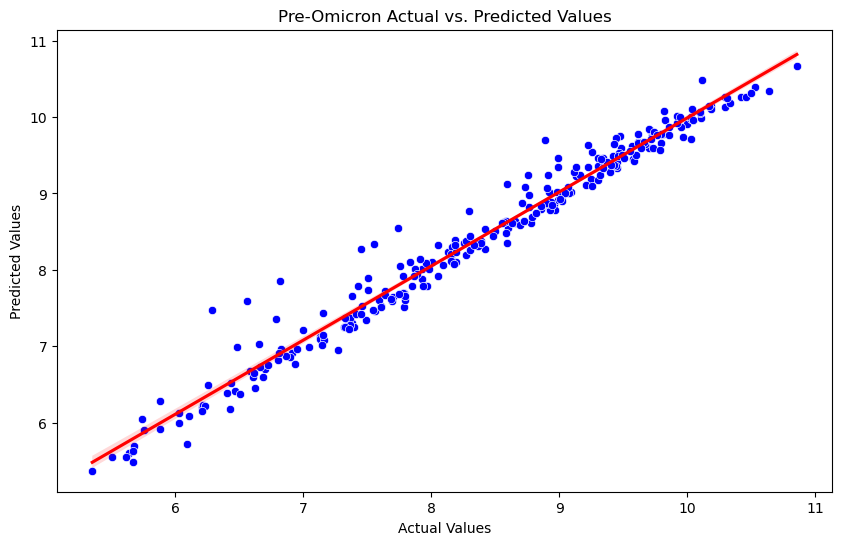

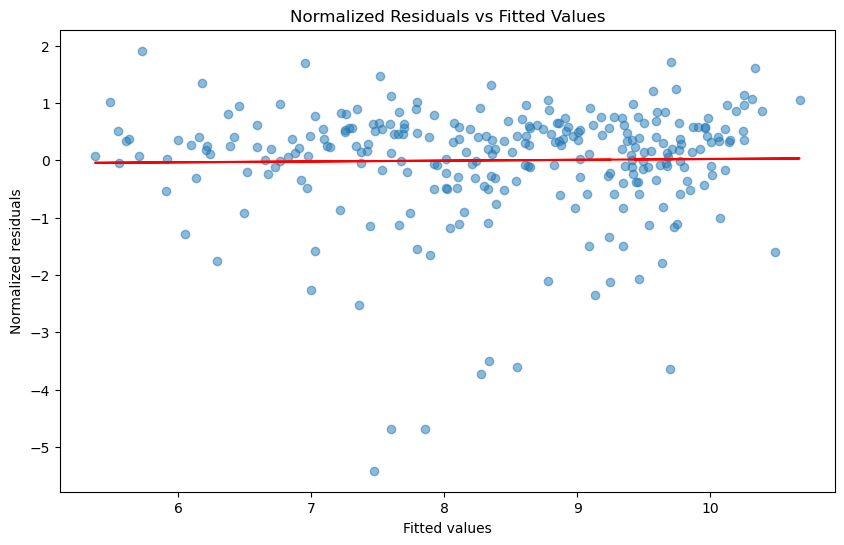

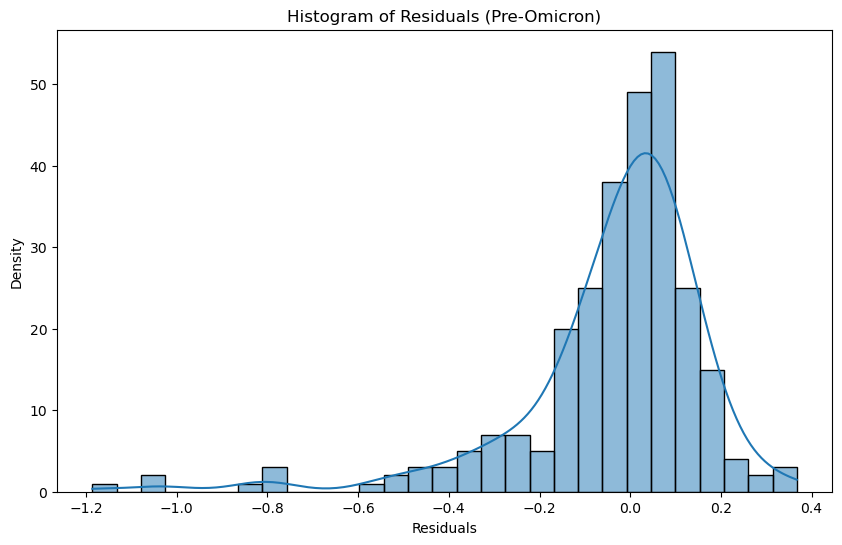

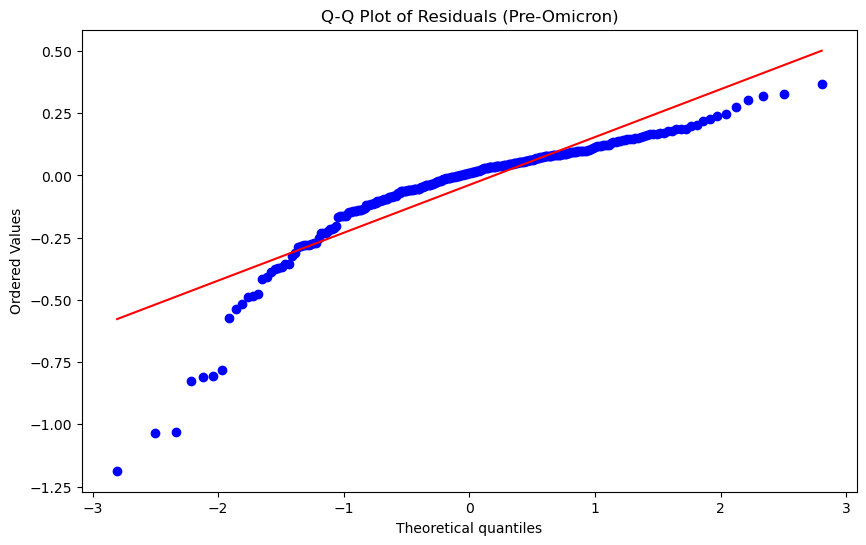

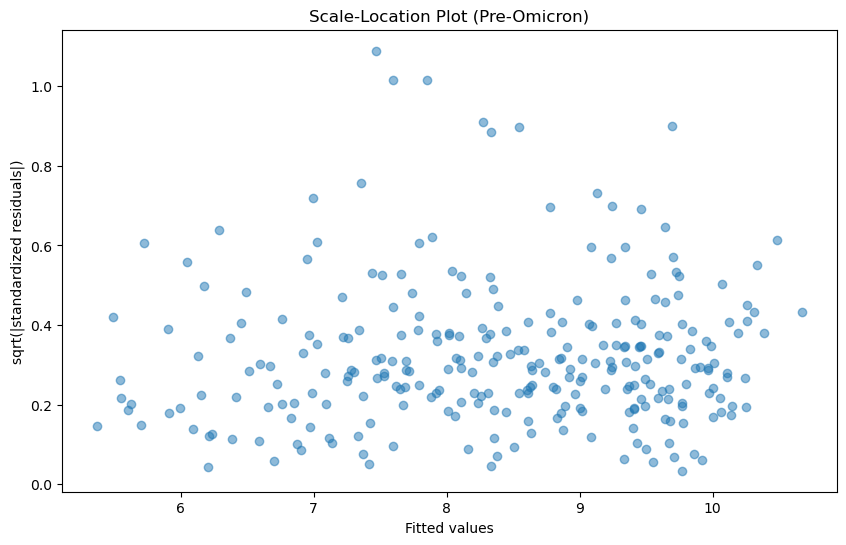

In [44]:
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, color='blue')
sns.regplot(x=y_test, y=y_pred, color='red', scatter=False)

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Pre-Omicron Actual vs. Predicted Values')
plt.show()


# Normalize the residuals
scaler = StandardScaler()
residuals_normalized = scaler.fit_transform(residuals.values.reshape(-1, 1))

# Create a linear regression object
linreg = LinearRegression()

# Fit the linear regression to the data
linreg.fit(y_pred.reshape(-1,1), residuals_normalized)

# Create predicted values for the trendline
trendline = linreg.predict(y_pred.reshape(-1,1))

# Create the plot
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals_normalized, alpha=0.5)
plt.plot(y_pred, trendline, color='red')
plt.title('Normalized Residuals vs Fitted Values')
plt.xlabel('Fitted values')
plt.ylabel('Normalized residuals')
plt.show()


plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Histogram of Residuals (Pre-Omicron)')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.show()


plt.figure(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals (Pre-Omicron)')
plt.show()


plt.figure(figsize=(10, 6))
plt.scatter(y_pred, np.sqrt(np.abs(residuals)), alpha=0.5)
plt.title('Scale-Location Plot (Pre-Omicron)')
plt.xlabel('Fitted values')
plt.ylabel('sqrt(|standardized residuals|)')
plt.show()


#### Thought I was done, but want to try one more model type: LinearTrees!

In [ ]:
# sample_copy_df = sample_date_df.copy()

# sample_copy_df.dropna(inplace=True)

# X = sample_copy_df.drop(columns=['Gene Copies (N1/L)','Sample Date', 'Test Date'], axis=1)

# y = sample_copy_df['Gene Copies (N1/L)']

# X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


# y_train = np.log(y_train)
# y_test = np.log(y_test)

In [ ]:
# lintree = LinearTreeRegressor(base_estimator=LinearRegression())

# lintree_pipeline = Pipeline([
#     ('preprocessor', preprocessor),
#     ('to_sparse', FunctionTransformer(csr_matrix, validate=False)),  # convert to sparse
#     ('to_dense', FunctionTransformer(lambda x: x.toarray(), validate=False)), # convert to dense. lintree requires this
#     ('model',  lintree)
# ])

# lintree_pipeline.fit(X_train, y_train)

# y_pred = lintree_pipeline.predict(X_test)

# print(f'R-squared score on training data: {lintree_pipeline.score(X_train, y_train)}')
# print(f'R2 test score: {r2_score(y_test, y_pred)}')
# print(f'Mean squared error: {mean_squared_error(y_test, y_pred)}')
# print(f'Mean absolute error: {mean_absolute_error(y_test, y_pred)}')
# print(f'Mean absolute percentage error: {mean_absolute_percentage_error(y_test, y_pred)}')
# print(f'Explained variance score (modified R2 test score): {explained_variance_score(y_test, y_pred)}')



### Well, that was a terrible model for this data, but seemed interesting! 